# PyTorch & MNIST Intro

Let's go through a simple example of Pytorch and MNIST as a way to level set NNs and the use of notebooks.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as pl
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Dataset

MNIST is probably the most traditionally used dataset for neural networks, as it is a relatively challenging problem in computer vision: recognizing single-digit numbers from a hand-written digital format. Classically, this dataset takes the form of samples of $28 \times 28$ matrices.

In [2]:
batch_size_train = 64
batch_size_test = 1000

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

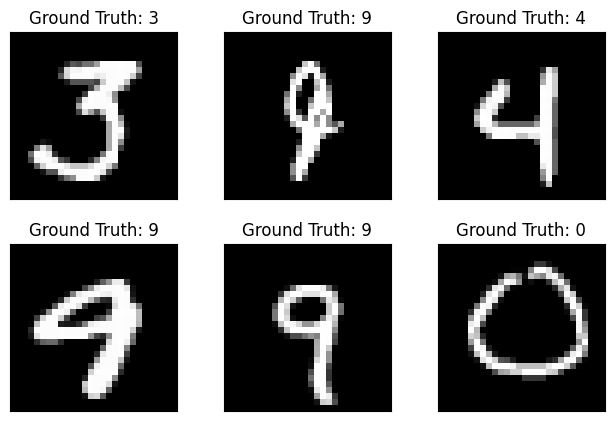

In [5]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Ground Truth: {}".format(example_targets[i]))
    pl.xticks([])
    pl.yticks([])
pl.show()

## Building the model

We need to specify the model through a Python class. Below we show how to create a Feedforward Neural Network model using Pytorch.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes) 

    def forward(self, x):
        out = self.fc1(x)
        return F.log_softmax(out)

You'll need to instantiate this class as well as an optimizer, which will apply an algorithm to find the internal parameters of that model, such as matrix weights and biases. As an example, we will use the Stochastic Gradient Descent algorithm.

In [8]:
learning_rate = 0.001
momentum = 0.1
log_interval = 10

In [9]:
network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

## Training

Next, we will define the training procedure.

In [10]:
n_epochs = 20

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
! mkdir -p results

In [12]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

In [13]:
train(1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.462653


/var/folders/hq/b0bc4svd5zv_ypq24th7bcdr0000gn/T/ipykernel_19758/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [640/60000 (1%)]	Loss: 2.314634
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.172709
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.038150
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.011766
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.793893
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.784094
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.759681
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.595977
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.612938
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.453784
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.386518
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.438524
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.395226
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.237687
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.228426
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.189160
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.303519
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.156207
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.144378
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.040590
Train Epoch: 1 [13440/60

<br />
Alongside trainig, we will also monitor the performance of the model on a set of samples not seen during the training.

In [14]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [15]:
test()

/var/folders/hq/b0bc4svd5zv_ypq24th7bcdr0000gn/T/ipykernel_19758/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/Users/ayinfly/anaconda3/envs/dsc80/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5596, Accuracy: 8696/10000 (87%)



## Training and evaluating for multiple epochs

Let's train now for all desired epochs.

In [16]:
for epoch in range(2, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.666574
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.541078
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.564097
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.666229


/var/folders/hq/b0bc4svd5zv_ypq24th7bcdr0000gn/T/ipykernel_19758/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.488055
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.434858
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.543594
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.447622
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.549790
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.652385
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.670172
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.586397
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.554512
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.585008
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.654413
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.667827
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.639856
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.650934
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.545639
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.532475
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.734861
Train Epoch: 2 [13440/60000 (22%)]	Loss: 0.680403
Train Epoch: 2 [14080/60000 (23%)]	Loss: 0.570716
Train Epoch: 2 [14720/60000 (25%)]	Loss: 0.624159
Train Epoch: 2 [1

# Model performance

Finally, we can inspect the results.

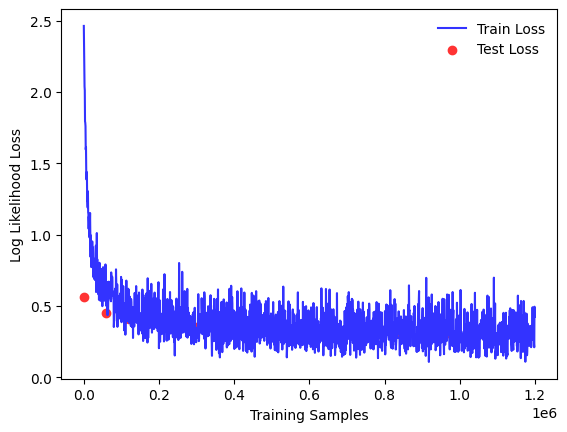

In [17]:
fig = pl.figure()
pl.plot(train_counter, train_losses, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

It's always important to inspect anecdotes to convince yourself the model is behind as expected.

In [18]:
with torch.no_grad():
  output = network(example_data.reshape(1000, 28*28))

/var/folders/hq/b0bc4svd5zv_ypq24th7bcdr0000gn/T/ipykernel_19758/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


**Challenge:** Can you explain why we are using `torch.no_grad()`?

**Answer:** We don't need the values of the gradients when we are looking at the model's performance without actually using the model itself

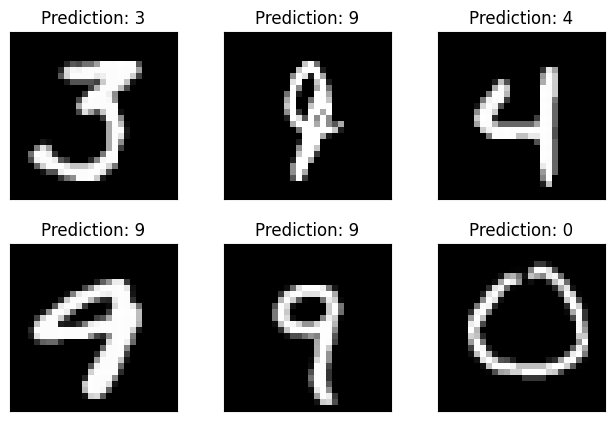

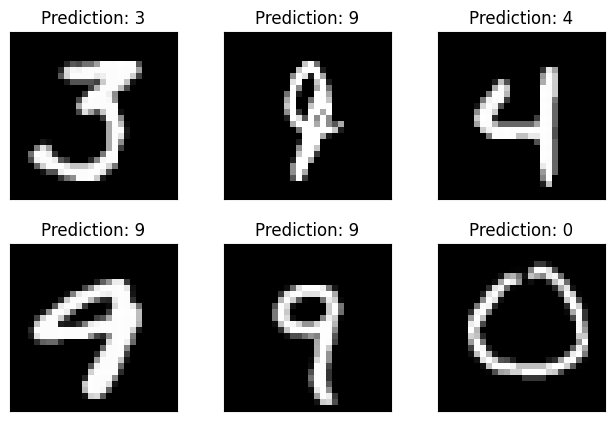

In [19]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    pl.xticks([])
    pl.yticks([])
fig

**Challenge:** Re-do the plot above, but showcasing only miss-classifications (i.e. cases in which the model did wrong).

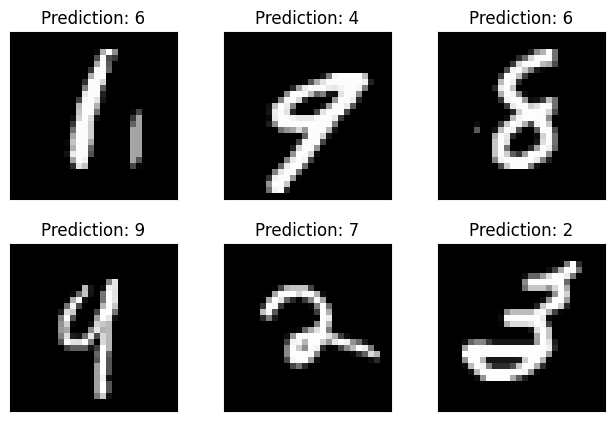

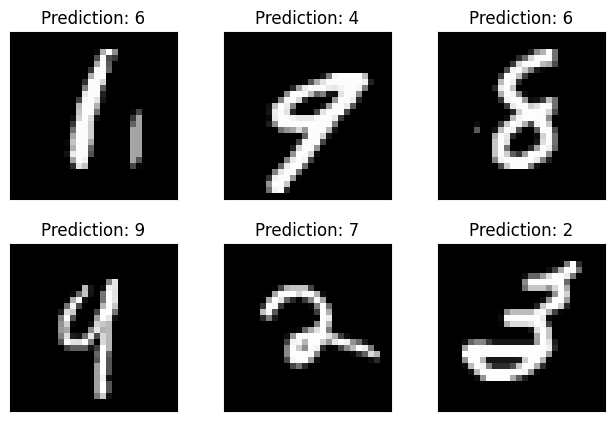

In [20]:
fig = pl.figure()

# wrong prediction stuffs
incorrect_indices = [] 
predictions = output.data.max(1, keepdim=True)[1]
for i in range(len(example_data)):
    if predictions[i].item() != example_targets[i].item():  # Check if prediction is wrong
        incorrect_indices.append(i)
        
for i in range(min(6, len(incorrect_indices))):
    idx = incorrect_indices[i]
    pl.subplot(2, 3, i + 1)
    pl.tight_layout()
    pl.imshow(example_data[idx][0], cmap='gray', interpolation='none')
    pl.title("Prediction: {}".format(predictions[idx].item()))
    pl.xticks([])
    pl.yticks([])
fig

## Loading trained models

Eventually, you will want to load the model you trained in the past for either running inference or continue the training procedure. The functions we developed above save artifacts contain all of the metadata and data about the model, assuming you have the right model class. Let's inspect those files: 

In [21]:
! ls results

model2_iteration-1.pth      optimizer2_iteration-1.pth
model2_iteration-2.pth      optimizer2_iteration-2.pth
model2_iteration-3.pth      optimizer2_iteration-3.pth
model2_iteration-4.pth      optimizer2_iteration-4.pth
model2_iteration-5.pth      optimizer2_iteration-5.pth
model_iteration-1.pth       optimizer_iteration-1.pth
model_iteration-10.pth      optimizer_iteration-10.pth
model_iteration-11.pth      optimizer_iteration-11.pth
model_iteration-12.pth      optimizer_iteration-12.pth
model_iteration-13.pth      optimizer_iteration-13.pth
model_iteration-14.pth      optimizer_iteration-14.pth
model_iteration-15.pth      optimizer_iteration-15.pth
model_iteration-16.pth      optimizer_iteration-16.pth
model_iteration-17.pth      optimizer_iteration-17.pth
model_iteration-18.pth      optimizer_iteration-18.pth
model_iteration-19.pth      optimizer_iteration-19.pth
model_iteration-2.pth       optimizer_iteration-2.pth
model_iteration-20.pth      optimizer_iteration-20.pth
model_iterat

To load a model:

In [22]:
trained_model = FeedforwardNeuralNetModel()
model_state_dict = torch.load("results/model_iteration-1.pth")
trained_model.load_state_dict(model_state_dict)

<All keys matched successfully>

Before proceeding, let's inspect `model_state_dict`

In [23]:
model_state_dict.keys()

odict_keys(['fc1.weight', 'fc1.bias'])

In [24]:
model_state_dict['fc1.weight'].shape

torch.Size([10, 784])

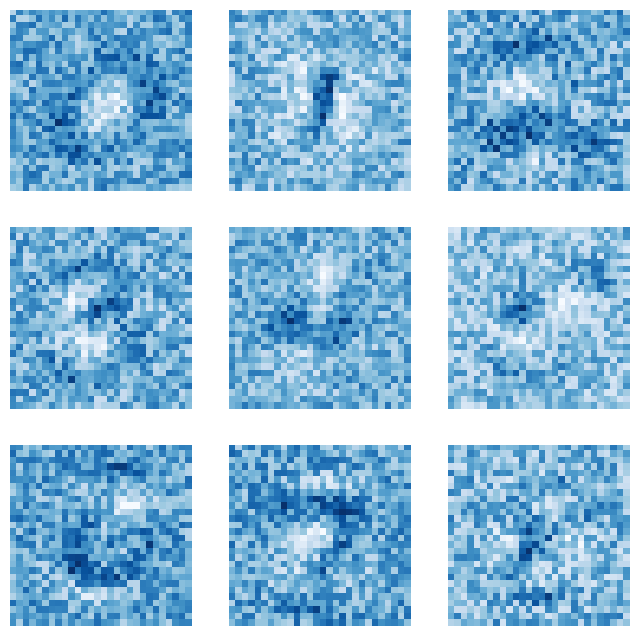

In [25]:
f,axs = pl.subplots(3,3, figsize=(8,8))

c = 0
for ax in axs:
    for sax in ax:
        sax.imshow(model_state_dict['fc1.weight'][c].reshape((28,28)), 
                   cmap = pl.get_cmap('Blues'))
        c += 1
        sax.axis('off')

pl.show()

Let's do the same for the optimizer

In [26]:
optimizer = optim.SGD(trained_model.parameters(), lr=learning_rate, momentum=momentum)
optimizer_state_dict = torch.load("results/optimizer_iteration-3.pth")
optimizer.load_state_dict(optimizer_state_dict)

In [27]:
optimizer_state_dict.keys()

dict_keys(['state', 'param_groups'])

**Challenge:** Can you make sense of the data in this dictionary?

**Answer:** State contains the values for the different parameters that are in param_groups

## Final challenges

* What happens if you use only 10% of the available training data? Plot the difference in performance of the network.
* What happens if you remove 80% of all samples with label 5. Do you see a difference in performance? Is this difference homogeneous?
* What happens if you change parameters like the learnign rate and momentum? Plot the difference.
* Can you add more layers to this neural network? Start with one additional layer (often called "hidden layer"). What changes can you observe in doing so?
* Can you add regularization to this model? Look for L1, L2, and drop-out regularizations. What changes do you observe?
* [stretch] Can you change this model and turn it into a convolutional neural network?

#### What happens if you use only 10% of the available training data? Plot the difference in performance of the network.

using only 10% of the data will make the model less accurate on the testing data since it has less exposure to different variations of the data making it harder to generalize

In [28]:
n_epochs = 20

train_losses2 = []
train_counter2 = []
test_losses2 = []
test_counter2 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [29]:
def train_10(epoch):
    network.train()
    num_batches = int(len(train_loader) * 0.1)

    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx >= num_batches:
            break
        
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses2.append(loss.item())
            train_counter2.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model2_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer2_iteration-{epoch}.pth')

In [30]:
def test_10():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses2.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [31]:
for epoch in range(1, n_epochs + 1): # starts from the second iteration
  train_10(epoch)
  test_10()

/var/folders/hq/b0bc4svd5zv_ypq24th7bcdr0000gn/T/ipykernel_19758/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.298169
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.334891
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.232779
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.175910
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.300272
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.325750
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.319295
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.328470
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.264369
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.378572

Test set: Avg. loss: 0.3002, Accuracy: 9148/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.208442
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.474199
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.262073
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.409215
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.227297
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.254625
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.230098
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.232610
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.365325
Train Epoch: 2 [5760/60000 (10%)]	Los

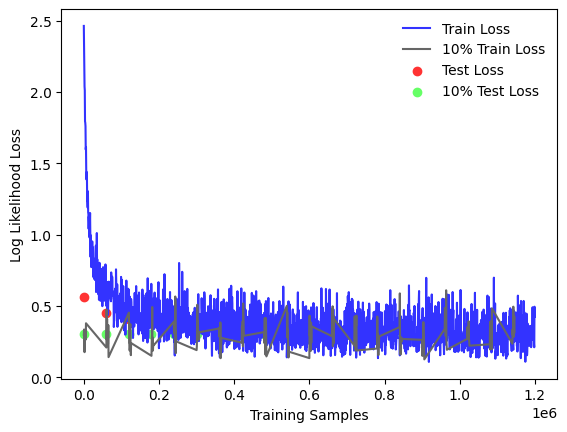

In [32]:
fig = pl.figure()
pl.plot(train_counter, train_losses, color=(0.2, 0.2, 1.0))
pl.plot(train_counter2, train_losses2, color=(0.4, 0.4, 0.4))
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))
pl.scatter(test_counter2[:-1], test_losses2, color=(0.4, 1, 0.4))

pl.legend(['Train Loss', '10% Train Loss', 'Test Loss', '10% Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

#### What happens if you remove 80% of all samples with label 5. Do you see a difference in performance? Is this difference homogeneous?

there is a slight decrease in performance, the most likely change is that the model is worse at evaluating 5s when testing

In [33]:
full_train_dataset = torchvision.datasets.MNIST(
    './files/', train=True, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

filtered_data = []
filtered_targets = []
for i in range(len(full_train_dataset)):
    data, target = full_train_dataset[i]
    if target == 5:
        if torch.rand(1).item() > 0.8:  # Keep 20% of the samples with label '5'
            filtered_data.append(data)
            filtered_targets.append(target)
    else:
        filtered_data.append(data)
        filtered_targets.append(target)

filtered_train_dataset = torch.utils.data.TensorDataset(torch.stack(filtered_data), torch.tensor(filtered_targets))

train_loader = torch.utils.data.DataLoader(
    filtered_train_dataset,
    batch_size=batch_size_train,
    shuffle=True
)

In [34]:
n_epochs = 20

train_losses2 = []
train_counter2 = []
test_losses2 = []
test_counter2 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [35]:
def train_10(epoch):
    network.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses2.append(loss.item())
            train_counter2.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model2_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer2_iteration-{epoch}.pth')

In [36]:
def test_10():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses2.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [37]:
for epoch in range(1, n_epochs + 1): # starts from the second iteration
  train_10(epoch)
  test_10()

/var/folders/hq/b0bc4svd5zv_ypq24th7bcdr0000gn/T/ipykernel_19758/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/55625 (0%)]	Loss: 0.541830
Train Epoch: 1 [640/55625 (1%)]	Loss: 0.176718
Train Epoch: 1 [1280/55625 (2%)]	Loss: 0.261431
Train Epoch: 1 [1920/55625 (3%)]	Loss: 0.227989
Train Epoch: 1 [2560/55625 (5%)]	Loss: 0.389481
Train Epoch: 1 [3200/55625 (6%)]	Loss: 0.301572
Train Epoch: 1 [3840/55625 (7%)]	Loss: 0.328518
Train Epoch: 1 [4480/55625 (8%)]	Loss: 0.187525
Train Epoch: 1 [5120/55625 (9%)]	Loss: 0.395991
Train Epoch: 1 [5760/55625 (10%)]	Loss: 0.247703
Train Epoch: 1 [6400/55625 (11%)]	Loss: 0.174708
Train Epoch: 1 [7040/55625 (13%)]	Loss: 0.304733
Train Epoch: 1 [7680/55625 (14%)]	Loss: 0.250472
Train Epoch: 1 [8320/55625 (15%)]	Loss: 0.521512
Train Epoch: 1 [8960/55625 (16%)]	Loss: 0.475181
Train Epoch: 1 [9600/55625 (17%)]	Loss: 0.300757
Train Epoch: 1 [10240/55625 (18%)]	Loss: 0.232778
Train Epoch: 1 [10880/55625 (20%)]	Loss: 0.339854
Train Epoch: 1 [11520/55625 (21%)]	Loss: 0.430239
Train Epoch: 1 [12160/55625 (22%)]	Loss: 0.277319
Train Epoch: 1 [12800/55625 (

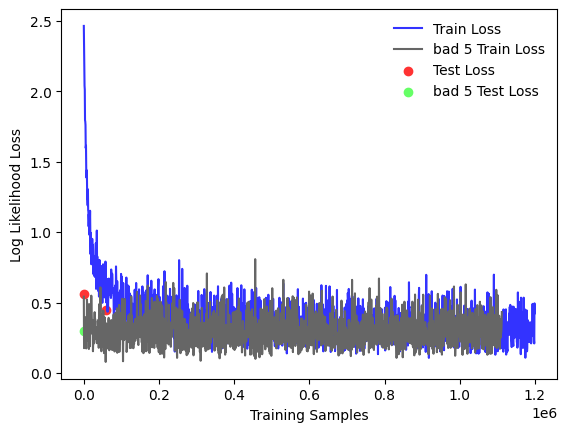

In [38]:
fig = pl.figure()
pl.plot(train_counter, train_losses, color=(0.2, 0.2, 1.0))
pl.plot(train_counter2, train_losses2, color=(0.4, 0.4, 0.4))
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))
pl.scatter(test_counter2[:-1], test_losses2, color=(0.4, 1, 0.4))

pl.legend(['Train Loss', 'bad 5 Train Loss', 'Test Loss', 'bad 5 Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

### What happens if you change parameters like the learnign rate and momentum? Plot the difference.

too high of a momentum or learning rate causes the model to diverge from the ideal point while too low of either causes the model to dconverge too slowly. The graph below demonstrates the model getting further away with each iteration

In [39]:
n_epochs = 20

train_losses2 = []
train_counter2 = []
test_losses2 = []
test_counter2 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [40]:
learning_rate = 1
momentum = 1
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [41]:
def train_change(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses2.append(loss.item())
            train_counter2.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration2-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration2-{epoch}.pth')

In [42]:
def test_change():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses2.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [43]:
for epoch in range(1, n_epochs + 1): # starts from the second iteration
  train_change(epoch)
  test_change()

/var/folders/hq/b0bc4svd5zv_ypq24th7bcdr0000gn/T/ipykernel_19758/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/55625 (0%)]	Loss: 0.138643
Train Epoch: 1 [640/55625 (1%)]	Loss: 84.844994
Train Epoch: 1 [1280/55625 (2%)]	Loss: 83.314301
Train Epoch: 1 [1920/55625 (3%)]	Loss: 54.522255
Train Epoch: 1 [2560/55625 (5%)]	Loss: 74.552414
Train Epoch: 1 [3200/55625 (6%)]	Loss: 87.856644
Train Epoch: 1 [3840/55625 (7%)]	Loss: 120.545013
Train Epoch: 1 [4480/55625 (8%)]	Loss: 184.275894
Train Epoch: 1 [5120/55625 (9%)]	Loss: 113.881081
Train Epoch: 1 [5760/55625 (10%)]	Loss: 231.689331
Train Epoch: 1 [6400/55625 (11%)]	Loss: 157.501312
Train Epoch: 1 [7040/55625 (13%)]	Loss: 72.832642
Train Epoch: 1 [7680/55625 (14%)]	Loss: 32.647621
Train Epoch: 1 [8320/55625 (15%)]	Loss: 164.534912
Train Epoch: 1 [8960/55625 (16%)]	Loss: 257.797516
Train Epoch: 1 [9600/55625 (17%)]	Loss: 153.400421
Train Epoch: 1 [10240/55625 (18%)]	Loss: 102.186569
Train Epoch: 1 [10880/55625 (20%)]	Loss: 526.548767
Train Epoch: 1 [11520/55625 (21%)]	Loss: 199.713913
Train Epoch: 1 [12160/55625 (22%)]	Loss: 702.00927

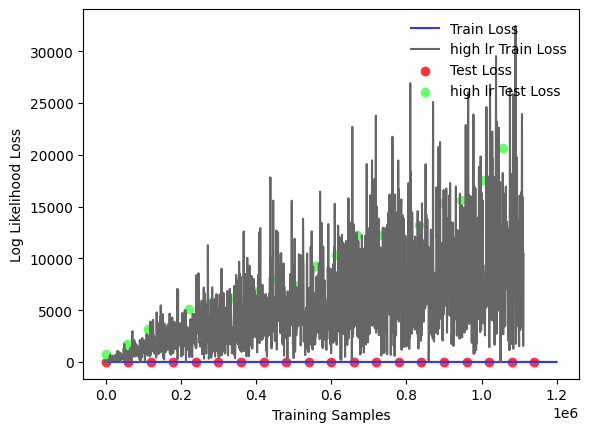

In [44]:
fig = pl.figure()
pl.plot(train_counter, train_losses, color=(0.2, 0.2, 1.0))
pl.plot(train_counter2, train_losses2, color=(0.4, 0.4, 0.4))
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))
pl.scatter(test_counter2[:-1], test_losses2, color=(0.4, 1, 0.4))

pl.legend(['Train Loss', 'high lr Train Loss', 'Test Loss', 'high lr Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

### Can you add more layers to this neural network? Start with one additional layer (often called "hidden layer"). What changes can you observe in doing so?

The model reaches a minimum much slower than usual which is most likely due to the complexity increasing. using a hidden layer should allow the model to learn more features since it remembers a larger amount of connections

In [45]:
class BigNet(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        hidden_dim = 128
        super(BigNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, num_classes)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        out = self.fc2(x)
        return F.log_softmax(out)

In [46]:
network = BigNet()

In [47]:
learning_rate = 0.001
momentum = 0.1
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [48]:
n_epochs = 20

train_losses2 = []
train_counter2 = []
test_losses2 = []
test_counter2 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [49]:
def train_change(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses2.append(loss.item())
            train_counter2.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration2-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration2-{epoch}.pth')

In [50]:
def test_change():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses2.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [51]:
for epoch in range(1, n_epochs + 1): # starts from the second iteration
  train_change(epoch)
  test_change()

/var/folders/hq/b0bc4svd5zv_ypq24th7bcdr0000gn/T/ipykernel_19758/1909510652.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/55625 (0%)]	Loss: 2.347960
Train Epoch: 1 [640/55625 (1%)]	Loss: 2.287635
Train Epoch: 1 [1280/55625 (2%)]	Loss: 2.305537
Train Epoch: 1 [1920/55625 (3%)]	Loss: 2.284802
Train Epoch: 1 [2560/55625 (5%)]	Loss: 2.214876
Train Epoch: 1 [3200/55625 (6%)]	Loss: 2.190390
Train Epoch: 1 [3840/55625 (7%)]	Loss: 2.175873
Train Epoch: 1 [4480/55625 (8%)]	Loss: 2.190293
Train Epoch: 1 [5120/55625 (9%)]	Loss: 2.160255
Train Epoch: 1 [5760/55625 (10%)]	Loss: 2.147709
Train Epoch: 1 [6400/55625 (11%)]	Loss: 2.108612
Train Epoch: 1 [7040/55625 (13%)]	Loss: 2.073686
Train Epoch: 1 [7680/55625 (14%)]	Loss: 1.995658
Train Epoch: 1 [8320/55625 (15%)]	Loss: 2.016652
Train Epoch: 1 [8960/55625 (16%)]	Loss: 2.036066
Train Epoch: 1 [9600/55625 (17%)]	Loss: 1.938219
Train Epoch: 1 [10240/55625 (18%)]	Loss: 1.968909
Train Epoch: 1 [10880/55625 (20%)]	Loss: 1.986694
Train Epoch: 1 [11520/55625 (21%)]	Loss: 1.918928
Train Epoch: 1 [12160/55625 (22%)]	Loss: 1.955278
Train Epoch: 1 [12800/55625 (

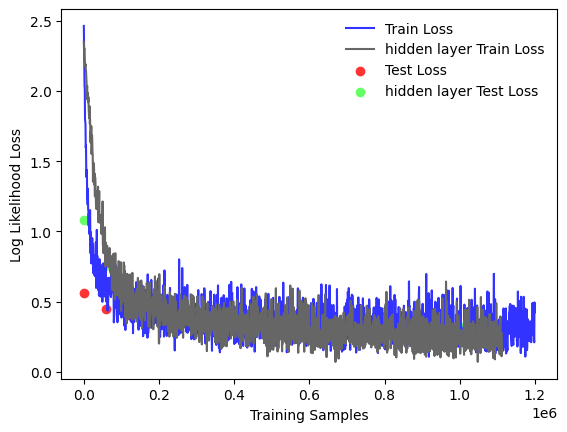

In [52]:
fig = pl.figure()
pl.plot(train_counter, train_losses, color=(0.2, 0.2, 1.0))
pl.plot(train_counter2, train_losses2, color=(0.4, 0.4, 0.4))
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))
pl.scatter(test_counter2[:-1], test_losses2, color=(0.4, 1, 0.4))

pl.legend(['Train Loss', 'hidden layer Train Loss', 'Test Loss', 'hidden layer Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

### Can you add regularization to this model? Look for L1, L2, and drop-out regularizations. What changes do you observe?

I don't observe any changes using these techniques, but what is supposed to happen is that L1 regularization is supposed to ignore unimportant features while l2 and dropout is supposed to help with generalization to unseen features

In [60]:
network = FeedforwardNeuralNetModel()

In [61]:
learning_rate = 0.001
momentum = 0.1
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-3)

In [62]:
n_epochs = 20

train_losses2 = []
train_counter2 = []
test_losses2 = []
test_counter2 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [63]:
def train_change(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses2.append(loss.item())
            train_counter2.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration2-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration2-{epoch}.pth')

In [64]:
def test_change():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses2.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [65]:
for epoch in range(1, n_epochs + 1): # starts from the second iteration
  train_change(epoch)
  test_change()

/var/folders/hq/b0bc4svd5zv_ypq24th7bcdr0000gn/T/ipykernel_19758/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/55625 (0%)]	Loss: 2.518563
Train Epoch: 1 [640/55625 (1%)]	Loss: 2.197653
Train Epoch: 1 [1280/55625 (2%)]	Loss: 2.008603
Train Epoch: 1 [1920/55625 (3%)]	Loss: 1.957660
Train Epoch: 1 [2560/55625 (5%)]	Loss: 1.887938
Train Epoch: 1 [3200/55625 (6%)]	Loss: 1.775019
Train Epoch: 1 [3840/55625 (7%)]	Loss: 1.591538
Train Epoch: 1 [4480/55625 (8%)]	Loss: 1.579851
Train Epoch: 1 [5120/55625 (9%)]	Loss: 1.442142
Train Epoch: 1 [5760/55625 (10%)]	Loss: 1.454573
Train Epoch: 1 [6400/55625 (11%)]	Loss: 1.396710
Train Epoch: 1 [7040/55625 (13%)]	Loss: 1.361612
Train Epoch: 1 [7680/55625 (14%)]	Loss: 1.342358
Train Epoch: 1 [8320/55625 (15%)]	Loss: 1.259833
Train Epoch: 1 [8960/55625 (16%)]	Loss: 1.048201
Train Epoch: 1 [9600/55625 (17%)]	Loss: 1.180506
Train Epoch: 1 [10240/55625 (18%)]	Loss: 1.037964
Train Epoch: 1 [10880/55625 (20%)]	Loss: 1.083713
Train Epoch: 1 [11520/55625 (21%)]	Loss: 1.252509
Train Epoch: 1 [12160/55625 (22%)]	Loss: 1.022767
Train Epoch: 1 [12800/55625 (

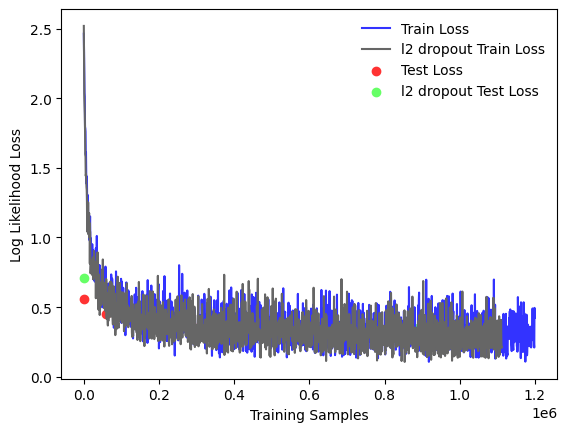

In [66]:
fig = pl.figure()
pl.plot(train_counter, train_losses, color=(0.2, 0.2, 1.0))
pl.plot(train_counter2, train_losses2, color=(0.4, 0.4, 0.4))
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))
pl.scatter(test_counter2[:-1], test_losses2, color=(0.4, 1, 0.4))

pl.legend(['Train Loss', 'l2 dropout Train Loss', 'Test Loss', 'l2 dropout Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()